#### Movie Example

In [ ]:
from ethograph import minimal_dt_from_audio
import os


N_trials = 1
fps = 24 
audio_sr = 44100 


data_folder = r"C:\Users\aksel\Documents\Code\EthoGraph\data\Night_of_the_Living_Dead"

dt = minimal_dt_from_audio(video_path=os.path.join(data_folder, "movie.mp4"),
                           fps=fps,
                           audio_path=os.path.join(data_folder, "movie.wav"),
                           audio_sr=audio_sr)

dt.to_netcdf(os.path.join(data_folder, "movie.nc"))

#### Some old GP code

In [ ]:
%load_ext autoreload
%autoreload 2

from ethograph.utils.paths import get_session_path, extract_trial_info_from_filename
from ethograph import TrialTree, add_changepoints_to_ds, set_media_attrs
from ethograph.features.changepoints import find_troughs_binary, find_nearest_turning_points_binary
import audioio as aio
from ethograph.features.filter import envelope
import os
import numpy as np
from pathlib import Path
import xarray as xr


data_folder = r"C:\Users\aksel\Documents\Code\ethograph\GP2025\Example_data"
N_trials = 1
fps = 30 # frames per second of video
audio_sr = 44100 # samplingrate of audio
n_cameras = 2
video_extension = ".mp4"
n_microphones = 2
mic_extension = ".mp3"

individuals = ["Poppy", "Ivy", "Daisy", "Lily"]




ds_list = []
for trial in range(1, N_trials + 1):
    

    mic1_path = os.path.join(data_folder, 'Audio', f"trial-{trial}_mic-1.mp3")
    mic2_path = os.path.join(data_folder, 'Audio', f"trial-{trial}_mic-2.mp3")

    mic1_data, _ = aio.load_audio(mic1_path) 
    mic2_data, _ = aio.load_audio(mic2_path) 

    # Only get first channel if stereo
    if mic1_data.ndim == 2 and mic1_data.shape[1] > 1:
        mic1_data = mic1_data[:, 0]
    if mic2_data.ndim == 2 and mic2_data.shape[1] > 1:
        mic2_data = mic2_data[:, 0]

    envelope1 = envelope(mic1_data, rate=audio_sr, cutoff=fps/4, env_rate=fps) # Nyquist frequency is fps/2, so cutoff should be less than that
    envelope2 = envelope(mic2_data, rate=audio_sr, cutoff=fps/4, env_rate=fps)


    envelopes = np.stack([envelope1, envelope2], axis=1)
    n_frames = len(envelope1)
    
    time_coords = np.arange(n_frames) / fps
    
    ds = xr.Dataset(
        data_vars={
            "envelope": (["time", "mics"], envelopes),
            "labels": (["time", "individuals"], np.zeros((n_frames, len(individuals))))
        },
        coords={
            "time": time_coords,
            "mics": [f"mic{i+1}" for i in range(n_microphones)],
            "individuals": individuals  
        }
    )


    ds = set_media_attrs(
        ds,
        cameras=[f"trial-{trial}_cam-{i+1}{video_extension}" for i in range(n_cameras)],
        mics=[f"trial-{trial}_mic-{i+1}{mic_extension}" for i in range(n_microphones)],
    )


    ds["envelope"].attrs["type"] = "features"
    ds.attrs["fps"] = fps
    ds.attrs["audio_sr"] = audio_sr
    ds.attrs["trial"] = trial

        
    
    ds = add_changepoints_to_ds(
        ds=ds, 
        target_feature="envelope",
        changepoint_name="troughs", 
        changepoint_func=find_troughs_binary, 
        prominence=0.5, 
        distance=2
    )
    
    ds = add_changepoints_to_ds(
        ds=ds,
        target_feature="envelope",
        changepoint_name="turning_points",
        changepoint_func=find_nearest_turning_points_binary,
        threshold=1.0,
        max_value=50,
        prominence=5,
        width=2
    )
    

    ds_list.append(ds)

dt = TrialTree.from_datasets(ds_list)
dt.to_netcdf(os.path.join(data_folder, f"Trial_data.nc"))

In [9]:
"cameras" in dt.itrial(0).attrs

True

In [ ]:
%load_ext autoreload
%autoreload 2

from ethograph.utils.paths import get_session_path
from ethograph import TrialTree, add_changepoints_to_ds, extract_trial_info_from_filename, set_media_attrs
from ethograph.features.changepoints import find_troughs_binary, find_nearest_turning_points_binary
import audioio as aio
from ethograph.features.filter import envelope
import os
import numpy as np
from pathlib import Path
import xarray as xr
from ethograph.features.audio_features import get_envelope


data_folder = r"C:\Users\aksel\Documents\Code\EthoGraph\data\Night_of_the_Living_Dead"
N_trials = 1
fps = 24 # frames per second of video
audio_sr = 44100 # samplingrate of audio
n_cameras = 1
video_extension = ".mp4"
n_microphones = 1
mic_extension = ".wav"

individuals = ["Ben", "Barbara", "Harry"]




ds_list = []
for trial in range(1, N_trials + 1):
    

    mic1_path = os.path.join(data_folder, 'movie.wav')
    print(mic1_path)
    
    
    envelope1, gen_wav_path = get_envelope(
        audio_path=mic1_path,
        target_fps=fps,
        audio_sr=audio_sr,
        cutoff=fps/4
    )
    
    if gen_wav_path is not None:
        print(f"Generated WAV file at: {gen_wav_path}")
        mic1_path = gen_wav_path

    
    n_frames = len(envelope1)
    
    time_coords = np.arange(n_frames) / fps
    
    ds = xr.Dataset(
        data_vars={
            "envelope": ("time", envelope1),
            "labels": (["time", "individuals"], np.zeros((n_frames, len(individuals))))
        },
        coords={
            "time": time_coords,
            "individuals": individuals  
        }
    )


    ds = set_media_attrs(
        ds,
        cameras=["movie.mp4"],
        mics=["movie.wav"],
    )


    ds["envelope"].attrs["type"] = "features"
    ds.attrs["fps"] = fps
    ds.attrs["audio_sr"] = audio_sr
    ds.attrs["trial"] = "movie1"

        
    
    ds = add_changepoints_to_ds(
        ds=ds, 
        target_feature="envelope",
        changepoint_name="troughs", 
        changepoint_func=find_troughs_binary, 
        prominence=0.5, 
        distance=2
    )
    
    ds = add_changepoints_to_ds(
        ds=ds,
        target_feature="envelope",
        changepoint_name="turning_points",
        changepoint_func=find_nearest_turning_points_binary,
        threshold=1.0,
        max_value=50,
        prominence=5,
        width=2
    )
    

    ds_list.append(ds)

dt = TrialTree.from_datasets(ds_list)
dt.to_netcdf(os.path.join(data_folder, f"MovieString.nc"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\aksel\Documents\Code\EthoGraph\data\Night_of_the_Living_Dead\movie.wav


In [2]:
dt.itrial(0)

<xarray.DatasetView> Size: 5MB
Dimensions:                  (time: 123690, individuals: 3)
Coordinates:
  * time                     (time) float64 990kB 0.0 0.04167 ... 5.154e+03
  * individuals              (individuals) <U7 84B 'Ben' 'Barbara' 'Harry'
Data variables:
    envelope                 (time) float64 990kB 1.069e-05 ... 0.02755
    labels                   (time, individuals) float64 3MB 0.0 0.0 ... 0.0 0.0
    envelope_troughs         (time) int8 124kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    envelope_turning_points  (time) int8 124kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    cameras:  ['cam1']
    cam1:     movie.mp4
    mics:     ['mic1']
    mic1:     movie.wav
    fps:      24
    trial:    movie1

In [15]:
def check_if_changepoints(ds):
    """Check if dataset contains any changepoint variables."""
    cp_ds = ds.filter_by_attrs(type="changepoints")
    return len(cp_ds.data_vars) > 0


from ethograph import TrialTree
import xarray as xr


path = r"C:\Users\aksel\Documents\Code\ethograph\data\Night_of_the_Living_Dead\Movie_noTP.nc"
dt = TrialTree.open(path)
ds = dt.itrial(0)
check = check_if_changepoints(ds)
print(check)

False


In [ ]:

dt.to_netcdf(path)

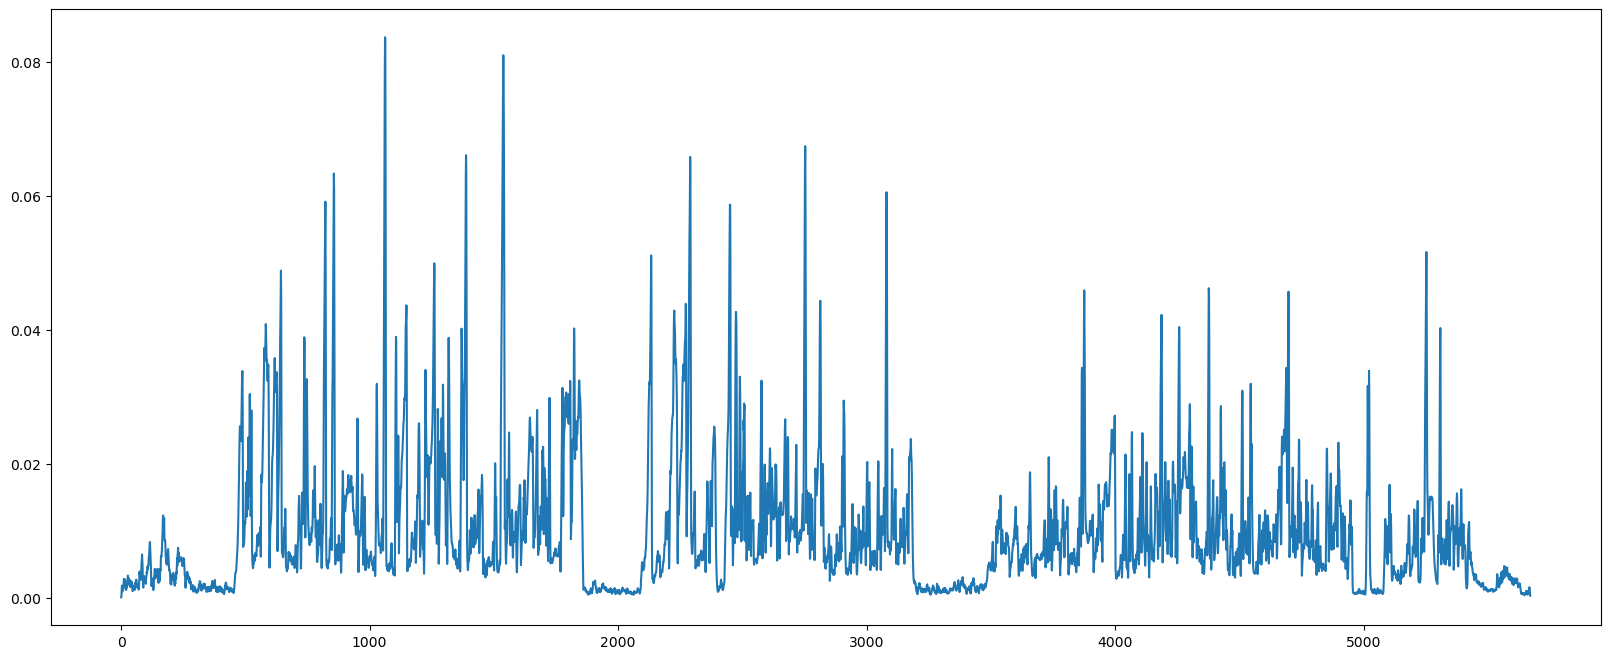

In [10]:
x = dt.trial(1).envelope.isel(mics=0).values


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 8))
plt.plot(x)

In [1]:
path = r"C:\Users\aksel\Documents\Code\ethograph\GP2025\Example_data\Trial_data.nc"

from ethograph import TrialTree


dt = TrialTree.open(path)
dt

<xarray.DataTree>
Group: /
└── Group: /trial_1
        Dimensions:                  (time: 5672, mics: 2, individuals: 4)
        Coordinates:
          * time                     (time) float64 45kB 0.0 0.03333 ... 189.0 189.0
          * mics                     (mics) <U4 32B 'mic1' 'mic2'
          * individuals              (individuals) <U5 80B 'Poppy' 'Ivy' 'Daisy' 'Lily'
        Data variables:
            envelope                 (time, mics) float64 91kB ...
            labels                   (time, individuals) float64 182kB ...
            envelope_troughs         (mics, time) int8 11kB ...
            envelope_turning_points  (mics, time) int8 11kB ...
        Attributes:
            cameras:  ['cam1', 'cam2']
            mics:     ['mic1', 'mic2']
            cam1:     trial-1_cam-1.mp4
            cam2:     trial-1_cam-2.mp4
            mic1:     trial-1_mic-1.mp3
            mic2:     trial-1_mic-2.mp3
            fps:      30
            audio_sr:       44100
            trial:    1

In [20]:
path = r"C:\Users\aksel\AppData\Local\Temp\MicrosoftEdgeDownloads\13cfaab1-b544-41cd-b981-d50003a7aff9\dyadgerbil-4m-e1_audio.h5"
# path = r"C:\Users\aksel\AppData\Local\Temp\MicrosoftEdgeDownloads\580a323f-4886-4a95-8a55-7aaec0c146c2\dyadmouse-24m-e3_audio.h5"


import h5py

# Read the HDF5 file
with h5py.File(path, 'r') as f:
    # List all keys in the file
    print("Keys in HDF5 file:", list(f.keys()))
    
    # Load audio data (adjust key name based on actual structure)
    audio_data = f['audio'][:]  # Replace 'audio' with the actual key name

Keys in HDF5 file: ['audio', 'length_idx', 'locations', 'locations_px', 'node_names']


In [21]:
x = audio_data[:, 0]

import audioio as aio

aio.write_audio('file.wav', x, 250000)